In [1]:
#!/usr/bin/env python3
#
# Copyright 2020 Ettus Research, a National Instruments Brand
#
# SPDX-License-Identifier: GPL-3.0-or-later
#
"""
Use a calibrated USRP as a power meter
"""

import sys
import signal
import argparse
import uhd
import uhd
from uhd import libpyuhd as lib
 # import libraries
import numpy as np
import threading
import time
import scipy.io
from scipy.signal import chirp, spectrogram

# import the gain tables
import matplotlib.pyplot as plt
from scipy.io import loadmat

import pylab as pyl

# These delays are used to align the buffers, used later in code
INIT_DELAY = 0.018

In [2]:
def setup_device( samp_rate, master_clock_rate, tx_gain, rx_gain):
    """
    set up everything except center frequency
    :return: a MultiUSRP device object, a tx_streamer, a rx_streamer
    """
    # define device parameters for daughter board and clock of the system
    args            = "type = b200"
    subdevice         = "A:A" # select subdevice in the daughterboard
    freq_clock_source = "internal"
    rx_band_width     = samp_rate
    tx_band_width     = samp_rate
    channel_list      = [0] 
    
    # create a usrp device and set up it with the device parameters defined above
    usrp = uhd.usrp.MultiUSRP(args)
    
    # set clock ant time
    # this sets the source of the frequency reference, typically a 10 MHz signal
    usrp.set_clock_source(freq_clock_source) 
    
    usrp.set_master_clock_rate(master_clock_rate)
    
    # select subdevice
    subdevice_spec = lib.usrp.subdev_spec(subdevice)
    usrp.set_rx_subdev_spec(subdevice_spec)
    usrp.set_tx_subdev_spec(subdevice_spec)
    print("Using Device: {}".format(usrp.get_pp_string()))
    
    # set sample rate of ADC/DAC
    usrp.set_tx_rate(samp_rate) # this will set over all channels
    print("Actual TX0 rate: {} Msps".format(usrp.get_tx_rate(0) / 1e6))
    usrp.set_rx_rate(samp_rate)
    print("Actual RX0 rate: {} Msps".format(usrp.get_rx_rate(0) / 1e6))
    
    # set bandwidth
    usrp.set_tx_bandwidth(tx_band_width, channel_list[0])
    
    usrp.set_rx_bandwidth(rx_band_width, channel_list[0])
    
    print("Actual RX0 bandwidth = {} MHz".format(usrp.get_rx_bandwidth(0)/ 1e6))

    print("Actual TX0 bandwidth = {} MHz".format(usrp.get_tx_bandwidth(0)/ 1e6))

    print("RX0 GAIN = {}".format(usrp.get_rx_gain(0)/ 1e6))
    usrp.set_rx_gain(rx_gain  , channel_list[0])
    print("Actual RX0 GAIN = {}".format(usrp.get_rx_gain(0)/ 1e6))
    
    # create stream args and tx streamer
    st_args = lib.usrp.stream_args("fc32", "sc16")
    st_args.channels = channel_list
    
    # create tx streamer
    tx_streamer = usrp.get_tx_stream(st_args)
    
    # create rx streamer
    rx_streamer = usrp.get_rx_stream(st_args)
    
    return usrp, tx_streamer, rx_streamer

def init_usrp_device_time(usrp):
    """
    set the usrp device time to zero
    :param usrp: a MultiUSRP Device
    """
    usrp.set_time_now(lib.types.time_spec(0.0))
    return


def tune_center_freq(usrp, target_center_freq):
    channel_list = [0]
    # tune center freqs on all channels
    usrp.set_rx_freq(lib.types.tune_request(target_center_freq),    0)

    # wait until the local oscillators are locked
    while not (usrp.get_rx_sensor("lo_locked", 0).to_bool() 
               and usrp.get_tx_sensor("lo_locked", 0).to_bool()): pass
    
    
    
def rx_and_save_data(usrp, rx_streamer, rx_buffer, rx_md, num_rx_samps, current_freq):
    stream_cmd            = lib.types.stream_cmd(lib.types.stream_mode.num_done)
    stream_cmd.num_samps  = num_rx_samps 
    stream_cmd.stream_now = False
    stream_cmd.time_spec  = usrp.get_time_now() + lib.types.time_spec(INIT_DELAY)
    rx_streamer.issue_stream_cmd(stream_cmd) # tells all channels to stream
    rx = rx_streamer.recv(rx_buffer, rx_md)



In [50]:
# from radar_parameters2 import * # import the parameters used in the radar

# define radar parameters
rx_freq           = 90e6

# device parameters
samp_rate         = 16e6
master_clock_rate = 16e6

# the second tx gain was used, but not needed if using gain tables
# less than 2.6e9
tx_gain  = 40
rx_gain  = 30

Using Device: Single USRP:
  Device: B-Series Device
  Mboard 0: B205mini
  RX Channel: 0
    RX DSP: 0
    RX Dboard: A
    RX Subdev: FE-RX1
  TX Channel: 0
    TX DSP: 0
    TX Dboard: A
    TX Subdev: FE-TX1

Actual TX0 rate: 16.0 Msps
Actual RX0 rate: 16.0 Msps
Actual RX0 bandwidth = 16.0 MHz
Actual TX0 bandwidth = 16.0 MHz
RX0 GAIN = 4e-05
Actual RX0 GAIN = 3e-05


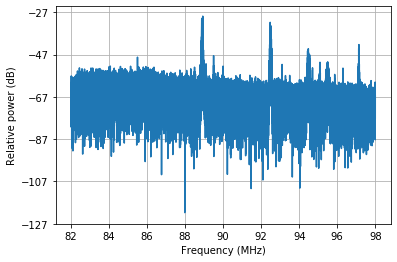

In [51]:

usrp, tx_streamer, rx_streamer = setup_device(samp_rate, master_clock_rate, tx_gain, rx_gain)

rx_md        = lib.types.rx_metadata()

num_samps = int(4096*10)

rx_buffer = np.zeros((1, num_samps), dtype=np.complex64)

# start the tx work and set up basics for B205
init_usrp_device_time(usrp) # set device time to 0

"""RX samples """
tune_center_freq(usrp, rx_freq)

rx_and_save_data(usrp, rx_streamer, rx_buffer, rx_md, num_samps, rx_freq)



pyl.psd(rx_buffer[0], NFFT=num_samps, Fs=samp_rate/1e6, Fc=rx_freq/1e6)
pyl.xlabel('Frequency (MHz)')
pyl.ylabel('Relative power (dB)')


pyl.show()
    






(1, 40960)


/home/aalmela/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


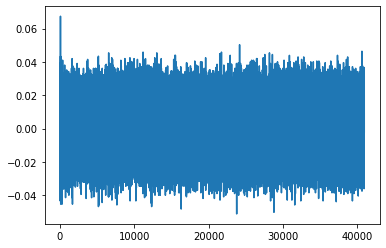

In [49]:
rx_buffer_list = np.array(rx_buffer)
#scipy.io.savemat("./Final/inside/loop2.mat", {"loop2": rx_buffer_list})
print(rx_buffer_list.shape)

plt.plot(rx_buffer[0])
plt.show()



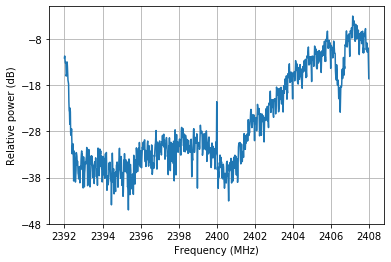

In [13]:
pyl.psd(rx_buffer[0], NFFT=1024, Fs=samp_rate/1e6, Fc=rx_freq/1e6)
pyl.xlabel('Frequency (MHz)')
pyl.ylabel('Relative power (dB)')


pyl.show()
